# Preprocessing
https://github.com/BrainLesion/preprocessing

## Run Preprocessing

In [15]:
import matplotlib.pyplot as plt
from auxiliary.normalization.percentile_normalizer import PercentileNormalizer
from auxiliary.turbopath import turbopath
from tqdm import tqdm
import os

from brainles_preprocessing.brain_extraction import HDBetExtractor
from brainles_preprocessing.modality import Modality
from brainles_preprocessing.preprocessor import Preprocessor
from brainles_preprocessing.registration import (
    ANTsRegistrator,
    NiftyRegRegistrator
)

/Users/LennartPhilipp/Desktop/Uni/Prowiss/Code/Brain_Mets_Classification/brain_mets_env/lib/python3.11/site-packages/brainles_preprocessing/registration/__init__.py:13: UserWarning:

eReg package not found. If you want to use it, please install it using 'pip install brainles_preprocessing[ereg]'



In [19]:
def preprocess_exam_in_brats_style(inputDir: str) -> None:
    """
    Perform BRATS (Brain Tumor Segmentation) style preprocessing on MRI exam data.

    Args:
        inputDir (str): Path to the directory containing raw MRI files for an exam.

    Raises:
        Exception: If any error occurs during the preprocessing.

    Example:
        brat_style_preprocess_exam("/path/to/exam_directory")

    This function preprocesses MRI exam data following the BRATS style, which includes the following steps:
    1. Normalization using a percentile normalizer.
    2. Registration and correction using NiftyReg.
    3. Brain extraction using HDBet.

    The processed data is saved in a structured directory within the input directory.

    Args:
        inputDir (str): Path to the directory containing raw MRI files for an exam.

    Returns:
        None
    """
    inputDir = turbopath(inputDir)
    print("*** start ***")
    brainles_dir = turbopath(inputDir) + "/" + inputDir.name + "_brainles"
    raw_bet_dir = brainles_dir / "raw_bet"

    t1_file = inputDir.files("*t1.nii.gz")
    t1c_file = inputDir.files("*t1c.nii.gz")
    t2_file = inputDir.files("*t2.nii.gz")
    flair_file = inputDir.files("*fla.nii.gz")

    # we check that we have only one file of each type
    if len(t1_file) == len(t1c_file) == len(t2_file) == len(flair_file) == 1:
        t1File = t1_file[0]
        t1cFile = t1c_file[0]
        t2File = t2_file[0]
        flaFile = flair_file[0]
        
        # normalizer
        percentile_normalizer = PercentileNormalizer(
            lower_percentile=0.1,
            upper_percentile=99.9,
            lower_limit=0,
            upper_limit=1,
        )
        # define modalities
        center = Modality(
            modality_name="t1c",
            input_path=t1cFile,
            raw_bet_output_path=raw_bet_dir / inputDir.name
            + "_t1c_bet_raw.nii.gz",
            atlas_correction=True,
            #normalizer=percentile_normalizer,
        )

        moving_modalities = [
            Modality(
                modality_name="t1",
                input_path=t1File,
                raw_bet_output_path=raw_bet_dir / inputDir.name
                + "_t1_bet_raw.nii.gz",
                atlas_correction=True,
                #normalizer=percentile_normalizer,
            ),
            Modality(
                modality_name="t2",
                input_path=t2File,
                raw_bet_output_path=raw_bet_dir / inputDir.name
                + "_t2_bet_raw.nii.gz",
                atlas_correction=True,
                #normalizer=percentile_normalizer,
            ),
            Modality(
                modality_name="flair",
                input_path=flaFile,
                raw_bet_output_path=raw_bet_dir / inputDir.name
                + "_fla_bet_raw.nii.gz",
                atlas_correction=True,
                #normalizer=percentile_normalizer,
            ),
        ]

        preprocessor = Preprocessor(
            center_modality=center,
            moving_modalities=moving_modalities,
            #registrator=NiftyRegRegistrator(),
            registrator=ANTsRegistrator(),
            brain_extractor=HDBetExtractor(),
            # optional: we provide a temporary directory as a sandbox for the preprocessin
            temp_folder="/Users/LennartPhilipp/Desktop/Uni/Prowiss/Code/preprocessing/temporary_directory",
            use_gpu=False,
            #limit_cuda_visible_devices="0",
        )

        preprocessor.run(
            save_dir_coregistration=brainles_dir + "/co-registration",
            save_dir_atlas_registration=brainles_dir + "/atlas-registration",
            save_dir_atlas_correction=brainles_dir + "/atlas-correction",
            save_dir_brain_extraction=brainles_dir + "/brain-extraction",
        )

In [20]:
#EXAMPLE_DATA_DIR = turbopath("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Code/preprocessing/sample_data")

EXAMPLE_DATA_DIR = turbopath("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Code/preprocessing/brain_les_minus_norm")

exams = EXAMPLE_DATA_DIR.dirs()

for exam in tqdm(exams):
    print("processing:", exam)
    preprocess_exam_in_brats_style(exam)

  0%|          | 0/1 [00:00<?, ?it/s]

processing: /Users/LennartPhilipp/Desktop/Uni/Prowiss/Code/preprocessing/brain_les_minus_norm/test_patient
*** start ***
File: /Users/LennartPhilipp/Desktop/Uni/Prowiss/Code/preprocessing/temporary_directory/atlas-space/atlas__t1c.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
1
2
3
4
exporting segmentation...


100%|██████████| 1/1 [07:49<00:00, 469.11s/it]


## Apply n4 bias correction

In [2]:
from intensity_normalization.normalize.zscore import ZScoreNormalize
import SimpleITK as sitk
from pathlib import Path
import os
import matplotlib.pyplot as plt
import numpy as np

In [3]:
path_to_preprocessed_images = Path("/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/derivatives/preprocessed_brainlesion_allpatients")

preprocessed_folder = Path("preprocessed")

brain_extracted_mask = Path("brain-extraction/atlas_bet_t1c_mask.nii.gz")

working on sub-01015961


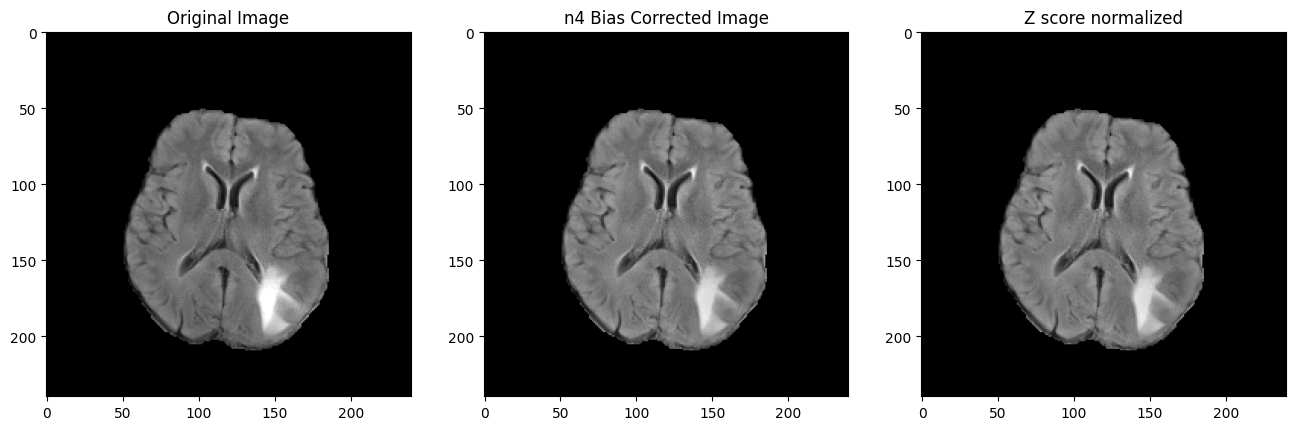

In [5]:
patients = [patient for patient in os.listdir(path_to_preprocessed_images) if os.path.isdir(os.path.join(path_to_preprocessed_images, patient))]

counter = 0

for patient in patients:
    if counter >= 1:
        continue

    print(f"working on {patient}")

    path_to_patient = path_to_preprocessed_images / patient
    if not os.path.exists(path_to_patient / "n4_corrected"):
        os.mkdir(path_to_patient / "n4_corrected")

    if not os.path.exists(path_to_patient / "z_score_normalized"):
        os.mkdir(path_to_patient / "z_score_normalized")

    # get brain mask image
    path_to_brain_mask = path_to_patient / brain_extracted_mask
    brain_mask = sitk.ReadImage(str(path_to_brain_mask), imageIO="NiftiImageIO")
    
    # convert to unsigned int
    brain_mask = sitk.Cast(brain_mask, sitk.sitkUInt8)

    # otsu_filter = sitk.OtsuThresholdImageFilter()
    # otsu_filter.SetInsideValue(0)
    # otsu_filter.SetOutsideValue(1)
    # binary_mask = otsu_filter.Execute(brain_mask_raw)


    # get preprocessed images
    preprocessed_images = [preprocessed for preprocessed in os.listdir(path_to_patient / preprocessed_folder) if ".nii.gz" in preprocessed]

    visualization = False

    for image in preprocessed_images:

        path_to_preprocessed_image = path_to_patient / preprocessed_folder / image
        preprocessed_image = sitk.ReadImage(str(path_to_preprocessed_image), imageIO="NiftiImageIO")

        # otsu_filter = sitk.OtsuThresholdImageFilter()
        # otsu_filter.SetInsideValue(0)
        # otsu_filter.SetOutsideValue(1)
        # binary_mask = otsu_filter.Execute(preprocessed_image)

        # apply n4 bias correction
        n4_corrected = apply_bias_correction(preprocessed_image, brain_mask)

        z_score_normalized = zscore_normalize(n4_corrected, brain_mask)

        #print(n4_corrected)

        #display difference between original and n4 corrected image
        #create two plots side by side
        if visualization == False:

            preprocessed_image_array = sitk.GetArrayFromImage(preprocessed_image)
            plt.figure(figsize=(16, 6))
            plt.subplot(1, 3, 1)
            plt.imshow(preprocessed_image_array[80, :, :], cmap="gray")
            plt.title("Original Image")

            plt.subplot(1, 3, 2)
            plt.imshow(sitk.GetArrayFromImage(n4_corrected)[80, :, :], cmap="gray")
            plt.title("n4 Bias Corrected Image")

            plt.subplot(1, 3, 3)
            plt.imshow(sitk.GetArrayFromImage(z_score_normalized)[80, :, :], cmap="gray")
            plt.title("Z score normalized")

            plt.show()


        visualization = True
        
        # save n4 corrected image
        sitk.WriteImage(n4_corrected, str(path_to_patient / "n4_corrected" / image))

        # save n4 corrected image
        sitk.WriteImage(z_score_normalized, str(path_to_patient / "z_score_normalized" / image))


    
    counter += 1
    



# get preprocessed images
# apply n4 bias correction
# save n4 corrected images in new folder


In [4]:
def apply_bias_correction(
    image: sitk.Image,
    mask_image = sitk.Image
) -> sitk.Image:
    """applies N4 bias field correction to image but keeps background at zero

    Keyword Arguments:
    image: sitk.Image = image to apply bias correction to

    Returns:
    image_corrected_masked: sitk.Image = N4 bias field corrected image
    """

    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    image_corrected = corrector.Execute(image, mask_image)

    mask_filter = sitk.MaskImageFilter()
    mask_filter.SetOutsideValue(0)
    image_corrected_masked = mask_filter.Execute(image_corrected, mask_image)

    return image_corrected_masked


In [11]:
path_to_check = "/Users/LennartPhilipp/Desktop/testing_data/derivatives/preprocessed_n4_z_score_brainlesion_20240531-150150/sub-01009590/normalized/sub-01009590_t2_normalized.nii.gz"

sitk_image = sitk.ReadImage(path_to_check, imageIO="NiftiImageIO")
numpy_image = sitk.GetArrayFromImage(sitk_image)

max_value = numpy_image.max()
min_value = numpy_image.min()
mean_value = numpy_image.mean()

print(max_value)
print(min_value)
print(mean_value)


1.0
0.0
0.070222594
